In [1]:
import numpy as np
import pandas as pd

# load the sarcoma transcriptome data
sarcoma_df = pd.read_csv('../Data/sarcoma-gene-exp-FPKM-zscore-no-label.csv')
sarcoma_df.shape

(206, 20605)

In [2]:
sarcoma_labels_df = pd.read_csv('../Data/sarcoma-gene-exp-FPKM-labels-only.csv')
sarcoma_labels_df.shape

(206, 1)

In [3]:
# Convert features to array
X = sarcoma_df.to_numpy()
X.shape

(206, 20605)

In [4]:
# Convert label df to np array
y_df = sarcoma_labels_df['label']
y = y_df.to_numpy()
print(y)

[4 2 2 1 5 3 2 4 4 3 4 4 4 3 0 3 1 4 2 4 4 0 2 4 3 3 3 2 0 4 4 5 3 3 2 4 4
 5 4 3 4 4 5 4 2 4 4 4 1 4 1 4 4 2 4 3 3 2 2 4 4 4 4 4 4 4 2 2 3 4 2 3 4 4
 3 4 3 2 4 3 2 3 4 4 3 4 3 4 3 4 4 1 3 4 4 4 0 4 3 4 3 3 3 5 2 0 3 3 1 1 4
 2 3 0 3 4 2 4 2 0 3 4 4 3 2 2 1 3 4 4 4 4 4 3 2 4 2 4 1 0 2 2 3 4 4 2 3 4
 4 3 1 3 4 3 4 2 2 1 3 2 2 0 4 2 1 4 2 1 4 3 3 4 2 4 2 4 3 4 2 1 3 4 2 4 4
 2 2 3 4 4 4 3 2 4 1 1 2 3 0 3 3 2 2 3 1 2]


In [5]:
# Get a count of the unique values in each categories 
unique_elements, counts_elements = np.unique(y, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[ 0  1  2  3  4  5]
 [10 17 44 50 80  5]]


In [6]:
# Split the data into three parts of development, validation and testing
# with ratios of 60%, 20%, and 20% respectively with stratification.
from sklearn.model_selection import train_test_split

In [7]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y, random_state=0
)

In [8]:
# split into development and validation sets
X_dev, X_val, y_dev, y_val = train_test_split(
    X_train, y_train, test_size=0.25,
    stratify=y_train, random_state=0
)

In [9]:
print(len(X_dev))
print(X_dev.shape)
print(len(X_val))
print(len(X_test))

123
(123, 20605)
41
42


In [10]:
import plaidml.keras
plaidml.keras.install_backend()
from keras.utils.np_utils import to_categorical
y_dev_cat = to_categorical(y_dev)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(5000, activation='relu', input_shape=(20605,)))
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_dev,
                    y_dev_cat, 
                    epochs=8, 
                    batch_size=32, 
                    validation_data=(X_val, y_val_cat))

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


Train on 123 samples, validate on 41 samples
Epoch 1/8
123/123 [==============================] - 2s 15ms/step - loss: 2.2286 - acc: 0.3415 - val_loss: 1.7444 - val_acc: 0.4146
Epoch 2/8
123/123 [==============================] - 1s 5ms/step - loss: 0.4647 - acc: 0.8780 - val_loss: 0.8330 - val_acc: 0.7561
Epoch 3/8
123/123 [==============================] - 1s 5ms/step - loss: 0.1257 - acc: 0.9919 - val_loss: 0.8024 - val_acc: 0.7561
Epoch 4/8
123/123 [==============================] - 1s 5ms/step - loss: 0.0674 - acc: 1.0000 - val_loss: 0.7946 - val_acc: 0.7561
Epoch 5/8
123/123 [==============================] - 1s 5ms/step - loss: 0.0494 - acc: 1.0000 - val_loss: 0.7857 - val_acc: 0.7317
Epoch 6/8
123/123 [==============================] - 1s 5ms/step - loss: 0.0394 - acc: 1.0000 - val_loss: 0.7827 - val_acc: 0.7561
Epoch 7/8
123/123 [==============================] - 1s 5ms/step - loss: 0.0328 - acc: 1.0000 - val_loss: 0.7762 - val_acc: 0.7561
Epoch 8/8
123/123 [==================

In [12]:
from collections import Counter
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

#smote_enn = SMOTEENN(random_state=0)
#smote_tomek = SMOTETomek(random_state=0)
# sm = BorderlineSMOTE(sampling_strategy='not majority', k_neighbors=4, m_neighbors=4, random_state=42)
sm = SMOTE(sampling_strategy='not majority', k_neighbors=2, random_state=42)
#sm = SMOTE(sampling_strategy={0: 40, 1: 40, 2: 40, 3: 40, 4: 40}, random_state=42)
#sm = SMOTE(sampling_strategy=.3, random_state=42)

X_res, y_res = sm.fit_resample(X_dev, y_dev)
# print('Resampled dataset shape %s' % Counter(y_res))


In [13]:
# Get a count of the unique values in each categories 
unique_elements, counts_elements = np.unique(y_res, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[ 0  1  2  3  4  5]
 [48 48 48 48 48 48]]


In [14]:
# find way to remove some of the synthetic class 5 observations

In [15]:
print(len(y_res))
print(len(X_res))

288
288


In [16]:
from keras.utils.np_utils import to_categorical
y_dev_cat = to_categorical(y_res)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [17]:
print(len(X_res))
print(len(X_val))
print(len(X_test))

288
41
42


In [18]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(5000, activation='relu', input_shape=(20605,)))
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_res,
                    y_dev_cat, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_val, y_val_cat))

Train on 288 samples, validate on 41 samples
Epoch 1/10
288/288 [==============================] - 1s 5ms/step - loss: 0.8101 - acc: 0.6771 - val_loss: 0.8351 - val_acc: 0.7317
Epoch 2/10
288/288 [==============================] - 1s 4ms/step - loss: 0.0843 - acc: 0.9965 - val_loss: 0.8061 - val_acc: 0.7073
Epoch 3/10
288/288 [==============================] - 1s 4ms/step - loss: 0.0412 - acc: 1.0000 - val_loss: 0.7911 - val_acc: 0.7317
Epoch 4/10
288/288 [==============================] - 1s 4ms/step - loss: 0.0278 - acc: 1.0000 - val_loss: 0.7898 - val_acc: 0.7317
Epoch 5/10
288/288 [==============================] - 1s 4ms/step - loss: 0.0211 - acc: 1.0000 - val_loss: 0.7879 - val_acc: 0.7073
Epoch 6/10
288/288 [==============================] - 1s 4ms/step - loss: 0.0171 - acc: 1.0000 - val_loss: 0.7862 - val_acc: 0.7073
Epoch 7/10
288/288 [==============================] - 1s 4ms/step - loss: 0.0143 - acc: 1.0000 - val_loss: 0.7826 - val_acc: 0.7317
Epoch 8/10
288/288 [===========

<function matplotlib.pyplot.show(*args, **kw)>

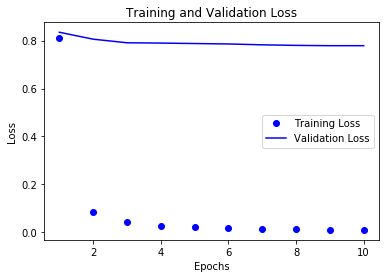

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show

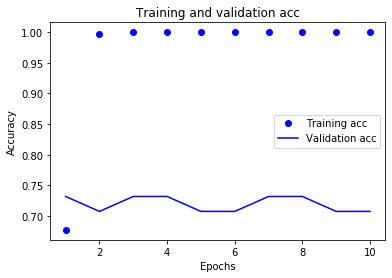

In [20]:
acc_values=history_dict['acc']
val_acc_values=history_dict['val_acc']
plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title("Training and validation acc")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
test_loss,test_acc=model.evaluate(X_test,y_test_cat)
print('test_acc',test_acc)

42/42 [==============================] - 1s 23ms/step
test_acc 0.7857142885526022


In [22]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(6)]
y_test_classes = np.argmax(y_test_cat, axis=-1)
print(classification_report(y_test_classes, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.22      1.00      0.36         2
     Class 1       1.00      0.25      0.40         4
     Class 2       0.67      0.44      0.53         9
     Class 3       0.80      0.80      0.80        10
     Class 4       0.94      0.94      0.94        16
     Class 5       0.00      0.00      0.00         1

    accuracy                           0.71        42
   macro avg       0.60      0.57      0.51        42
weighted avg       0.80      0.71      0.72        42



/Users/jeffreydelong/plaidml-venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_classes, predicted_classes)

array([[ 2,  0,  0,  0,  0,  0],
       [ 1,  1,  2,  0,  0,  0],
       [ 4,  0,  4,  1,  0,  0],
       [ 2,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  1, 15,  0],
       [ 0,  0,  0,  0,  1,  0]])